In [1]:
import numpy as np
import os
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

pd.set_option('display.max_columns', 200)

In [2]:
train = pd.read_csv('Data/Train_transactions.csv')
test = pd.read_csv('Data/Test_transactions.csv')
y = pd.read_csv('Data/Train_customers_repurchase.csv')

C:\ProgUT1\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
train.head()

,id_client,transaction_date,stores_nb,item_count,gross_amount,discount_amount,basket_value,payment_gift,payment_cheque,payment_cash,payment_card,email_domain,civility,zip_code,card_subscription,multicard,price_segmentation
0,37520523,2019-12-26T16:44:00.000Z,12015,57,138.69,0.49,138.20,0,0,1,0,NaN,MME,12420,NaN,0.0,NaN
1,84917629,2019-08-01T12:16:00.000Z,77131,6,9.87,0.00,9.87,0,0,1,0,NaN,MME,77450,NaN,0.0,NaN
2,20962900,2019-09-25T18:10:00.000Z,92786,6,26.25,2.21,24.04,0,0,0,1,GMAIL.COM,MME,92110,NaN,0.0,Quali
3,85917543,2020-01-24T17:34:00.000Z,21554,5,15.08,0.00,15.08,0,0,0,1,SFR.FR,M,21130,NaN,0.0,Mixte
4,6861392,2019-08-22T19:28:00.000Z,83820,25,81.16,30.60,50.56,0,0,0,1,ORANGE.FR,MME,83600,NaN,0.0,Mixte


In [4]:
train['card_sub'] = np.where(train['card_subscription'].isnull(), 0, 1)

In [5]:
train.transaction_date = pd.to_datetime(train.transaction_date)

In [6]:
train.dtypes

id_client                           int64
transaction_date      datetime64[ns, UTC]
stores_nb                           int64
item_count                          int64
gross_amount                      float64
discount_amount                   float64
basket_value                      float64
payment_gift                        int64
payment_cheque                      int64
payment_cash                        int64
payment_card                        int64
email_domain                       object
civility                           object
zip_code                           object
card_subscription                  object
multicard                         float64
price_segmentation                 object
card_sub                            int32
dtype: object

In [7]:
s = train.transaction_date.max() - train.transaction_date
train['last_visit'] = s.dt.days

In [8]:
train_ok = (
    train
    .groupby('id_client')
    .agg(
        last_visit = ('last_visit', 'min'),
        nb_purchases = ('id_client', 'count'),
        item_count = ('item_count', 'mean'),
        gross_amount = ('gross_amount', 'mean'),
        discount_amount = ('discount_amount', 'mean'),
        basket_value = ('basket_value', 'mean'),
        payment_gift = ('payment_gift', 'mean'),
        payment_cheque = ('payment_cheque', 'mean'),
        payment_cash = ('payment_cash', 'mean'),
        payment_card = ('payment_card', 'mean'),
        card_sub = ('card_sub', 'max')
    )
)

In [9]:
train_ok.head()

,last_visit,nb_purchases,item_count,gross_amount,discount_amount,basket_value,payment_gift,payment_cheque,payment_cash,payment_card,card_sub
id_client,,,,,,,,,,,
291,0,55,27.254545,75.480545,2.181636,73.298909,0.090909,0.0,0.000000,1.000000,0
365,52,25,5.600000,15.602000,0.078800,15.523200,0.040000,0.0,0.440000,0.560000,0
1800,6,78,25.141026,101.286282,11.272179,90.014103,0.269231,0.0,0.038462,0.961538,0
3471,139,60,6.766667,20.062667,0.142167,19.920500,0.000000,0.0,0.883333,0.116667,0
3961,310,3,43.666667,138.446667,0.540000,137.906667,0.000000,0.0,0.333333,0.666667,0


[(0.0, 250.0)]

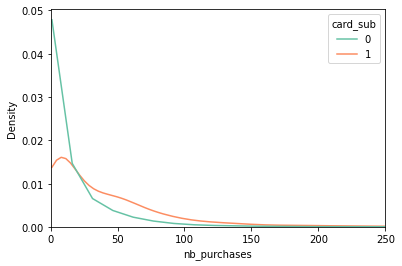

In [16]:
g = sns.kdeplot(data=train_ok, x="nb_purchases", hue="card_sub", cut=0, fill=False, common_norm=False, alpha=1, palette="Set2")
g.set(xlim=(0, 250))

[(0.0, 350.0)]

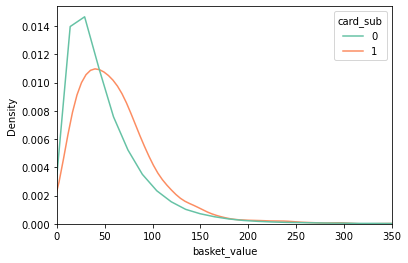

In [20]:
g = sns.kdeplot(data=train_ok, x="basket_value", hue="card_sub", cut=0, fill=False, common_norm=False, alpha=1, palette="Set2")
g.set(xlim=(0, 350))

<AxesSubplot:xlabel='card_sub', ylabel='basket_value'>

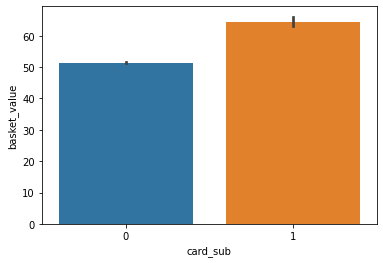

In [56]:
sns.barplot(data=train_ok, x="card_sub", y="basket_value")

In [21]:
train_ok.groupby('card_sub').count()

,last_visit,nb_purchases,item_count,gross_amount,discount_amount,basket_value,payment_gift,payment_cheque,payment_cash,payment_card
card_sub,,,,,,,,,,
0,155470,155470,155470,155470,155470,155470,155470,155470,155470,155470
1,4954,4954,4954,4954,4954,4954,4954,4954,4954,4954


In [22]:
train_ok = train_ok.fillna(0)

In [23]:
cible = y.sort_values('id_client')['repurchase']

In [24]:
test['card_sub'] = np.where(test['card_subscription'].isnull(), 0, 1)

test.transaction_date = pd.to_datetime(test.transaction_date).dt.date

s = test.transaction_date.max() - test.transaction_date
test['last_visit'] = s.dt.days

test_ok = (
    test
    .groupby('id_client')
    .agg(
        last_visit = ('last_visit', 'min'),
        nb_purchases = ('id_client', 'count'),
        item_count = ('item_count', 'mean'),
        gross_amount = ('gross_amount', 'mean'),
        discount_amount = ('discount_amount', 'mean'),
        basket_value = ('basket_value', 'mean'),
        payment_gift = ('payment_gift', 'mean'),
        payment_cheque = ('payment_cheque', 'mean'),
        payment_cash = ('payment_cash', 'mean'),
        payment_card = ('payment_card', 'mean'),
        card_sub = ('card_sub', 'max')
    )
)

In [25]:
test_ok.head()

,last_visit,nb_purchases,item_count,gross_amount,discount_amount,basket_value,payment_gift,payment_cheque,payment_cash,payment_card,card_sub
id_client,,,,,,,,,,,
2098,8,36,16.027778,47.153889,1.471667,45.682222,0.166667,0.083333,0.194444,0.722222,0
3399,0,103,13.320388,41.607476,0.554466,41.053010,0.009709,0.155340,0.077670,0.786408,0
3712,2,80,10.425000,27.929625,2.447250,25.482375,0.012500,0.000000,0.012500,0.925000,0
4664,3,51,15.470588,39.142745,0.985686,38.157059,0.039216,0.980392,0.019608,0.000000,0
6741,142,17,23.000000,69.735294,0.058824,69.676471,0.000000,0.941176,0.000000,0.058824,0


In [26]:
test_ok = test_ok.fillna(0)

In [27]:
test_ok.groupby('card_sub').count()

,last_visit,nb_purchases,item_count,gross_amount,discount_amount,basket_value,payment_gift,payment_cheque,payment_cash,payment_card
card_sub,,,,,,,,,,
0,38898,38898,38898,38898,38898,38898,38898,38898,38898,38898
1,1208,1208,1208,1208,1208,1208,1208,1208,1208,1208


In [28]:
train_ok_std = train_ok.copy()

In [29]:
train_ok_std[['last_visit', 'nb_purchases', 'item_count', 'gross_amount', 'discount_amount', 'basket_value', 'payment_gift', 'payment_cheque', 'payment_cash', 'payment_card']] = StandardScaler().fit_transform(train_ok[['last_visit', 'nb_purchases', 'item_count', 'gross_amount', 'discount_amount', 'basket_value', 'payment_gift', 'payment_cheque', 'payment_cash', 'payment_card']])

In [30]:
train_ok_std.head()

,last_visit,nb_purchases,item_count,gross_amount,discount_amount,basket_value,payment_gift,payment_cheque,payment_cash,payment_card,card_sub
id_client,,,,,,,,,,,
291,-0.911353,0.955822,0.808527,0.376474,-0.080622,0.426741,0.325085,-0.23284,-0.684834,0.824279,0
365,-0.437100,0.123161,-0.759533,-0.707689,-0.324150,-0.720608,-0.093335,-0.23284,0.672579,-0.385671,0
1800,-0.856632,1.594196,0.655482,0.843714,0.972147,0.758683,1.790706,-0.23284,-0.566179,0.718514,0
3471,0.356361,1.094599,-0.675051,-0.626924,-0.316812,-0.633283,-0.422094,-0.23284,2.040274,-1.604787,0
3961,1.915924,-0.487457,1.996969,1.516542,-0.270739,1.709765,-0.422094,-0.23284,0.343509,-0.092350,0


In [31]:
test_ok_std = test_ok.copy()

In [32]:
test_ok_std[['last_visit', 'nb_purchases', 'item_count', 'gross_amount', 'discount_amount', 'basket_value', 'payment_gift', 'payment_cheque', 'payment_cash', 'payment_card']] = StandardScaler().fit_transform(test_ok[['last_visit', 'nb_purchases', 'item_count', 'gross_amount', 'discount_amount', 'basket_value', 'payment_gift', 'payment_cheque', 'payment_cash', 'payment_card',]])

In [33]:
test_ok_std.head()

,last_visit,nb_purchases,item_count,gross_amount,discount_amount,basket_value,payment_gift,payment_cheque,payment_cash,payment_card,card_sub
id_client,,,,,,,,,,,
2098,-0.838680,0.411807,-0.002375,-0.139249,-0.188236,-0.122414,0.939308,0.361129,-0.082761,0.060025,0
3399,-0.911794,2.197936,-0.197185,-0.240892,-0.310766,-0.213970,-0.343706,0.873919,-0.442967,0.236602,0
3712,-0.893515,1.584787,-0.405521,-0.491552,-0.057906,-0.521925,-0.320889,-0.232324,-0.643992,0.617875,0
4664,-0.884376,0.811687,-0.042468,-0.286061,-0.253159,-0.271246,-0.102508,6.749482,-0.622067,-1.926839,0
6741,0.385980,-0.094707,0.499309,0.274577,-0.376980,0.352142,-0.423067,6.470210,-0.682550,-1.765013,0


In [34]:
rf_std_class = RandomForestClassifier(max_depth=4, min_samples_split=10,n_estimators=100, bootstrap=True, oob_score=True)
rf_std_class.fit(train_ok_std, cible)

RandomForestClassifier(max_depth=4, min_samples_split=10, oob_score=True)

In [35]:
predict_rf_std = rf_std_class.predict_proba(test_ok_std)

In [36]:
test_ok_std_reset = test_ok_std.reset_index()
test_ok_reset = test_ok.reset_index()

submission = pd.DataFrame({
    'Id': test_ok_std_reset.id_client,
    'Expected': predict_rf_std[:, 1]
})

submission.to_csv('submission_nb.csv', index = False, sep = ',', decimal = '.')

In [37]:
submission = submission.sort_values('Expected')

<AxesSubplot:xlabel='Expected', ylabel='Count'>

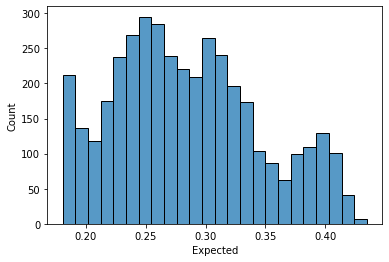

In [38]:
last_ind = int(submission.shape[0]*0.10)
last_ind
last10 = submission[-last_ind:]
sns.histplot(last10["Expected"])

In [39]:
last10

,Id,Expected
34256,82616753,0.180498
33691,81934812,0.180545
21281,34958900,0.180552
28464,38613876,0.180565
6713,11340499,0.180605
...,...,...
35566,84188558,0.425448
4608,8175046,0.425522
1514,3986580,0.426765
10363,18759170,0.427863


In [40]:
test_ok_reset["Customers class"] = np.where(test_ok_reset.id_client.isin(last10["Id"]) , 'top customers', 'else')
test_ok_reset[test_ok_reset["Customers class"]=='top customers']

,id_client,last_visit,nb_purchases,item_count,gross_amount,discount_amount,basket_value,payment_gift,payment_cheque,payment_cash,payment_card,card_sub,Customers class
1,3399,0,103,13.320388,41.607476,0.554466,41.053010,0.009709,0.155340,0.077670,0.786408,0,top customers
2,3712,2,80,10.425000,27.929625,2.447250,25.482375,0.012500,0.000000,0.012500,0.925000,0,top customers
3,4664,3,51,15.470588,39.142745,0.985686,38.157059,0.039216,0.980392,0.019608,0.000000,0,top customers
5,6951,0,203,10.743842,32.729852,7.486207,25.243645,0.113300,0.000000,0.000000,0.975369,1,top customers
6,8154,0,57,25.929825,76.648070,5.698596,70.949474,0.105263,0.000000,0.017544,0.982456,0,top customers
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40074,87995575,0,80,24.337500,74.135875,5.689875,68.446000,0.025000,0.687500,0.087500,0.225000,0,top customers
40082,87999756,4,87,28.436782,97.011494,10.654368,86.357126,0.126437,0.000000,0.068966,0.045977,0,top customers
40086,88001095,2,66,24.075758,70.606515,2.971061,67.635455,0.045455,0.015152,0.015152,0.969697,0,top customers
40090,88001678,6,60,31.250000,107.835500,20.582833,87.252667,0.516667,0.000000,0.000000,0.983333,0,top customers


[(0.0, 200.0)]

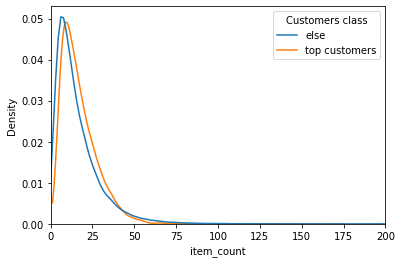

In [41]:
g =sns.kdeplot(data=test_ok_reset, x="item_count", hue="Customers class", cut=0, fill=False, common_norm=False, alpha=1)
g.set(xlim=(0, 200))

[(0.0, 200.0)]

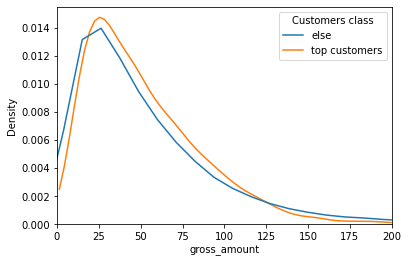

In [42]:
g = sns.kdeplot(data=test_ok_reset, x="gross_amount", hue="Customers class", cut=0, fill=False, common_norm=False, alpha=1)
g.set(xlim=(0, 200))

[(0.0, 200.0)]

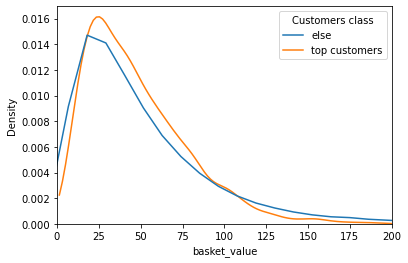

In [43]:
g =sns.kdeplot(data=test_ok_reset, x="basket_value", hue="Customers class", cut=0, fill=False, common_norm=False, alpha=1)
g.set(xlim=(0, 200))

[(0.0, 50.0)]

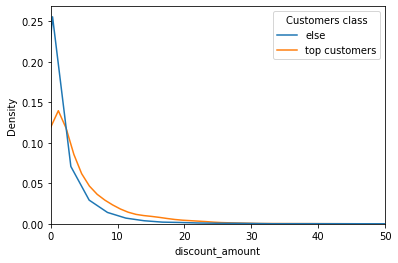

In [44]:
g = sns.kdeplot(data=test_ok_reset, x="discount_amount", hue="Customers class", cut=0, fill=False, common_norm=False, alpha=1)
g.set(xlim=(0, 25))

<AxesSubplot:xlabel='payment_card', ylabel='Density'>

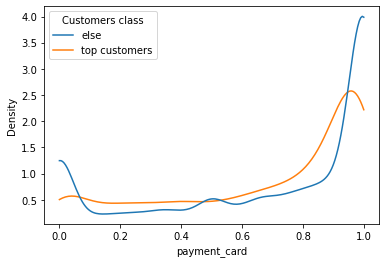

In [45]:
g = sns.kdeplot(data=test_ok_reset, x="payment_card", hue="Customers class", cut=0, fill=False, common_norm=False, alpha=1)
g

<AxesSubplot:xlabel='payment_gift', ylabel='Density'>

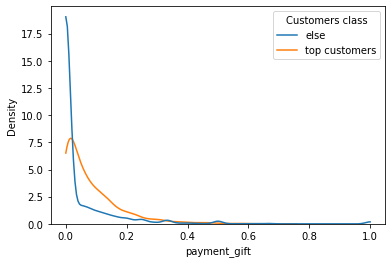

In [46]:
g = sns.kdeplot(data=test_ok_reset, x="payment_gift", hue="Customers class", cut=0, fill=False, common_norm=False, alpha=1)
g

[(0.0, 250.0)]

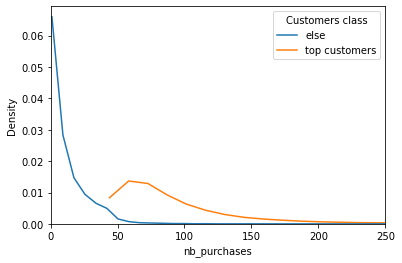

In [47]:
g = sns.kdeplot(data=test_ok_reset, x="nb_purchases", hue="Customers class", cut=0, fill=False, common_norm=False, alpha=1)
g.set(xlim=(0, 250))

<AxesSubplot:xlabel='card_sub', ylabel='discount_amount'>

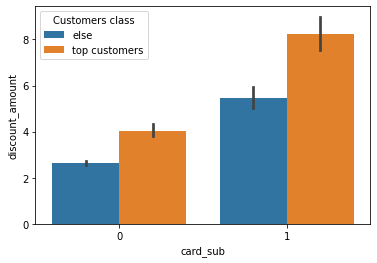

In [50]:
sns.barplot(data=test_ok_reset, x="card_sub", y="discount_amount", hue="Customers class")